# The Cellular Automaton Model of Investment Behaviour in the Stock Market

In this section we implement (in Python) a more advanced model compared to the one proposed in Hakman A. Wan's paper.

In particular, now we use a 2-dimensional grid, instead of a 1 dimensional one, and add complexity to the model by introducing macro-economic factors, and by modelling with greater depth the imitation behaviour among investors.

##### References
- [Yi-ming Wei, Shang-jun Ying, Ying Fan, Bing-Hong Wang, The cellular automaton model of investment behavior in the stock market, Physica A: Statistical Mechanics and its Applications, Volume 325, Issues 3–4, 2003, Pages 507-516, ISSN 0378-4371, https://doi.org/10.1016/S0378-4371(03)00144-4.](https://www.sciencedirect.com/science/article/pii/S0378437103001444)

### Introduction

As already mentioned, we now proceed to implement a two-dimensional cellular automata. 

As a consequence, the neighbourhood structure we adopt will differ from the one of the previous section, where, in practice, cell behaviour didn't really depend on neighbourhood behaviour, as the entire grid's state was considered.

For a 2-D cellular automata with a square lattice there are mainly two possible kinds of neighbourhood that may be adopted:
- Von Neumann neighbourhoods, where the value of the center cell is updated according to a rule that depends on the values of the non-diagonal neighbouring cells.
- Moore neighbourhoods, where the entirety of neighbouring cells are considered.

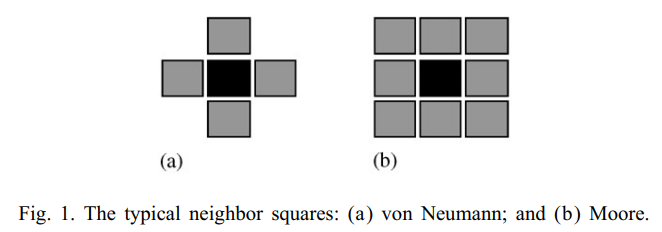
(*The image here provided was sourced from the original paper*)

In the specific case of this paper, a Moore neighbourhood structure was chosen.

### The Model

**Assumptions**
- The amount of money, and the number of shares held are infinite. 

**Layout**
- A cellular automaton represents a stock market. Every site in the cellular automaton represents an investor agent in the stock market.
- The state variable $S(i, j)(t)$ denotes the investment behavior of the agent at the site $(i, j)$ at time $t$; it can choose the following three different values: $S_b$ (representing buy), $S_h$ (representing hold), and $S_s$ (representing sell), i.e.,     $$S(i, j)(t) \in \{S_b, S_h, S_s\}$$
- Generally, the state of a given site in a time step will be determined by the states of itself and its neighbors in the previous time step, and the control variables, which can be formulated as follows:$$S(i, j)(t + 1) = F(S(i, j)(t), S(i, j)_L(t), R)$$ where $$S(i, j)_L(t) = \begin{pmatrix} S(i-1, j-1)(t), & S(i-1, j)(t), & S(i-1, j+1)(t) \\ S(i, j-1)(t),& & S(i, j+1)(t)\\S(i+1, j-1)(t), & S(i+1, j)(t), & S(i+1, j+1)(t)\end{pmatrix}$$
    represents the state of the neighbor sites for the site $(i, j)$, $R$ is the control variable and $F$ is the evolution rule of the cellular automaton.

**Investors' Imitation Behaviour**
-  The cellular states represent investment behaviour.
-  The investment behaviour of the neighbor sites is primarily determined as the most investors among them at the previous time step, according to the majority principle.
- The investment preference reflects the investor’s imitation behavior. $P(i, j)$ denotes the imitation probability of cellular in grid $(i, j)$, meaning that its state will change with a probability of $P(i, j)$ from the current state to the neighbor’s state which is the most common neighbors’ investment behavior, $P(i, j) \in [0, 1]$.
- When $P(i, j) \in [0, 0.5]$, the investment preference is anti-imitation; the strength of this anti-imitation behavior depends on how close $P(i, j)$ is to zero. When $P(i, j) \in (0.5, 1]$, the investment preference is imitation; the strength of this imitation behavior depends on how close $P(i, j)$ is to 1. When $P(i, j) = 0.5$, the investment preference is non-imitation. 
- The investment preference is the same for all investors, i.e., $P(i, j) = P$ for all $i, j$ and $P > 0.5$.

**Macrofactors**
- With a buying or selling coefficient, the macrofactors ($M_f \in [0, 1]$) increase or decrease the probabilities of the investors’ buying and selling. 
- When the macro situation is positive information, the buying probabilities of the investors will increase, and while the macro circumstance is negative information, corresponding to it, the selling probabilities of the investors will increase. $M_f$ is an adjusting coefficient of the transfer probability which is caused by the macro factors.

**Transfer Probabilities Management**
- During the evolution process, the values which are smaller than zero are regarded as zero and those which are larger than 1 are considered as 1.
- At the same time, the sum of the values of three transfer probabilities of each of the cellular automata is 1. If the sum is not 1, the evolution program will automatically adjust the transfer probabilities by which the behavior of the current cellular automata is altered into the behavior used by few investors in order to have the sum of the values of the probabilities above $1$. 

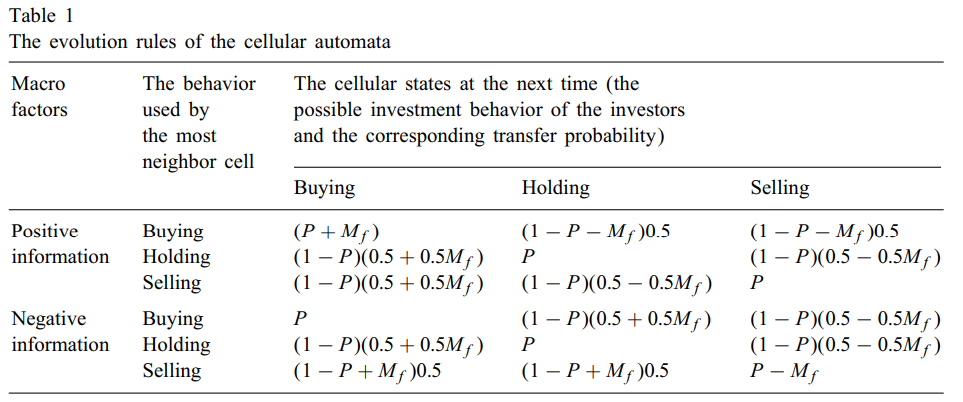 (*This table was sourced from the original paper*)

### Implementation

In this section we present the Python code that implements the model presented above. Analogously to the models previously illustrated, all the relevant functions were defined within a class object, to keep the code organized and maintainable.

The class `MarketSimulator2D_CA` requires as input the grid size, and whether the grid should be symmetric, as the one presented in the reference paper. We use square grids, so the grid size is supposed to represent the length of each side of the square in terms of cells. 
In addition, to actually run the simulation, the user needs to provide:
- The value of the maximum number of steps that will be run in the simulation.
- The macro coefficient ($M_{f}$), which must be chosen from the set $[0,1]$ as the influencing extent of the macro-factors.
- The probability $P$ related to the imitation behaviour of the investors. When $P=1$ the evolution rules are deterministic. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import statistics as stats
from matplotlib.colors import ListedColormap

In [ ]:
class MarketSimulator2D_CA:
    def __init__(self, grid_size, symmetric = False, random_grid_probs = None):
        self.grid_size = grid_size
        
        self.BUY = 1
        self.HOLD = 0
        self.SELL = -1

        self.random_grid_probs = random_grid_probs
        
        self.STATES = [self.BUY, self.HOLD, self.SELL]

        self.symmetric = symmetric
        self.grid = self.create_random_grid() if self.symmetric == False else self.create_symmetric_grid()
        
        # differently from Wan's paper implementation, here we decided to use a dictionary to store the time-series for the 3 states: buy, hold, and sell
        self.history = {"buy":[], "hold":[], "sell":[]}

    def create_random_grid(self):
        """
        Creates and returns a grid with a random initial state, assuming uniform probabilities for all states, by default.
        Allows custom starting probabilities 
        """

        # Verify that the inputted probabilities list has length 3 and is a stochastic vector
        if isinstance(self.random_grid_probs, list):
            assert np.sum(self.random_grid_probs) == 1
            assert len(self.random_grid_probs) == 3

        return np.random.choice(self.STATES, size=(self.grid_size, self.grid_size), p = self.random_grid_probs)
    
    def create_symmetric_grid(self):
        """ 
        Creates a symmetric grid, analogous to the one presented in the reference paper
        """
        grid = np.full((self.grid_size, self.grid_size), self.SELL, dtype=int)

        buy_sell_length  = self.grid_size//3+1
        hold_length = self.grid_size-buy_sell_length

        start_hold = buy_sell_length//2
        end_hold = -(buy_sell_length//2+buy_sell_length%2)

        grid[start_hold:end_hold, start_hold:end_hold] = self.HOLD

        start_buy =  hold_length//2
        end_buy = -(hold_length//2+hold_length%2)

        grid[start_buy:end_buy, start_buy:end_buy] = self.BUY

        return grid
    
    def upload_external_grid(self, external_grid):
        """ 
        Simple function that supports inputting externally generated grids as starting grids
        """
        self.grid = external_grid
       

    def get_majority_neighbor_state(self, i, j, macro_info):
        """
        Calculates the majority state among the 8 Moore neighbors of cell (i, j).
        Uses the provided grid and periodic boundary conditions.
        """
        # determine the neighbouring cells of the main cell, indexed by i and j
        grid = self.grid

        size = grid.shape[0]
        neighbor_states = []
        for di in [-1, 0, 1]:
            for dj in [-1, 0, 1]:
                if di == 0 and dj == 0:
                    continue

                ni, nj = (i + di) % size, (j + dj) % size
                neighbor_states.append(grid[ni, nj])

        # Count the number of neighbouring investors that have held, bought or sold the stock in the grid
        buy_count = neighbor_states.count(self.BUY)
        hold_count = neighbor_states.count(self.HOLD)
        sell_count = neighbor_states.count(self.SELL)

        # determine the majority neighbour state
        if buy_count > hold_count and buy_count > sell_count:
            return self.BUY
        elif sell_count > buy_count and sell_count > hold_count:
            return self.SELL
        
        # if a consent can't be found, decide depending on the macro state
        # While not explicitly indicated, we found this by trial and error when trying to replicate the images
        else:
            if macro_info == "positive":
                return self.BUY
            if macro_info == "negative":
                return self.SELL
            else:
                return self.HOLD

    def get_transition_probabilities(self, majority_state, P, Mf, macro_info): 
        """Calculates transition probabilities based on Table 1 from the paper."""
        probs = [0.0, 0.0, 0.0] # [prob_buy, prob_hold, prob_sell]

        if macro_info == "positive":
            if majority_state == self.BUY:
                probs = [P + Mf, (1 - P - Mf) * 0.5, (1 - P - Mf) * 0.5]
            elif majority_state == self.HOLD:
                probs = [(1 - P) * (0.5 + 0.5 * Mf), P, (1 - P) * (0.5 - 0.5 * Mf)]
            elif majority_state == self.SELL:
                probs = [(1 - P) * (0.5 + 0.5 * Mf), (1 - P) * (0.5 - 0.5 * Mf), P]
        
        elif macro_info == "negative":
            if majority_state == self.BUY:
                probs = [P, (1 - P) * (0.5 + 0.5 * Mf), (1 - P) * (0.5 - 0.5 * Mf)]
            elif majority_state == self.HOLD:
                probs = [(1 - P) * (0.5 - 0.5 * Mf), P, (1 - P) * (0.5 + 0.5 * Mf)]
            elif majority_state == self.SELL:
                probs = [(1 - P + Mf) * 0.5, (1 - P + Mf) * 0.5, P - Mf]

        elif macro_info == 'none':
            if majority_state == self.BUY:
                probs = [P, (1 - P) * 0.5, (1 - P) * 0.5]
            elif majority_state == self.HOLD:
                probs = [(1 - P) * 0.5, P, (1 - P) * 0.5]
            elif majority_state == self.SELL:
                probs = [(1 - P) * 0.5, (1 - P) * 0.5, P]

        clipped_probs = np.clip(probs, 0, 1)

        prob_sum = np.sum(clipped_probs)

        # if the sum of the probabilities is 0, return uniform probabilities for all states
        if prob_sum == 0:
            return [1/3, 1/3, 1/3]

        # renormalize the probabilities to ensure that they sum to one
        normalized_probs = clipped_probs / prob_sum

        # store the an array containing the transition probabilities for the 3 states, in order: BUY, HOLD, SELL
        return [normalized_probs[0], normalized_probs[1], normalized_probs[2]]
        

    def update_grid(self, P, Mf, macro_info):
        """Computes the next state of the entire grid based on the current_grid."""
        grid = self.grid
        new_grid = np.zeros_like(grid)

        for i in range(self.grid_size):
            for j in range(self.grid_size):

                majority = self.get_majority_neighbor_state(i, j, macro_info)
                probs = self.get_transition_probabilities(majority, P, Mf, macro_info)

                new_grid[i, j] = np.random.choice(self.STATES, p=probs)
        
        self.grid = new_grid

    # helper function to update the history at each step
    def update_history(self):
        self.history["buy"].append(np.sum(self.grid == self.BUY))
        self.history["hold"].append(np.sum(self.grid == self.HOLD))
        self.history["sell"].append(np.sum(self.grid == self.SELL)) 
    
    def run_simulation(self, num_steps, P, Mf, macro_info):

        # initialize an empty history dictionary, and a new grid
        self.grid = self.create_random_grid() if self.symmetric == False else self.create_symmetric_grid()
        self.history = {"buy":[], "hold":[], "sell":[]}

        for step in range(num_steps):
            self.update_history()
            self.update_grid(P, Mf, macro_info)

    def plot_grid(self, title=None, ax = None):
        ax = ax
        
        if ax == None:
            fig, ax = plt.subplots(1,1,figsize = (10,10))
        
        cmap = ListedColormap(['red', 'lightgray', 'green'])
        bounds = [-1.5, -0.5, 0.5, 1.5]
        norm = plt.matplotlib.colors.BoundaryNorm(bounds, cmap.N)

        ax.imshow(self.grid, cmap=cmap, norm=norm)
        ax.set_title(title if title else "Current Grid State")
        ax.set_xticks([])
        ax.set_yticks([])


    def plot_hist(self, title=None, ax = None):

        ax = ax

        if ax == None:
            fig, ax = plt.subplots(1,1,figsize = (10,10))         
        
        ax.plot(self.history["buy"], label="Buy", color='green')
        ax.plot(self.history["hold"], label="Hold", color='gray', linestyle='--')
        ax.plot(self.history["sell"], label="Sell", color='red')        

        ax.set_xlabel('evolving steps')
        ax.set_ylabel('Number of Investors')
        ax.set_title(title if title else "Investment Behavior Over Time")
        ax.legend()


### Replicating the Paper's Figures

In [3]:
simulator = MarketSimulator2D_CA(grid_size=50, symmetric= True)

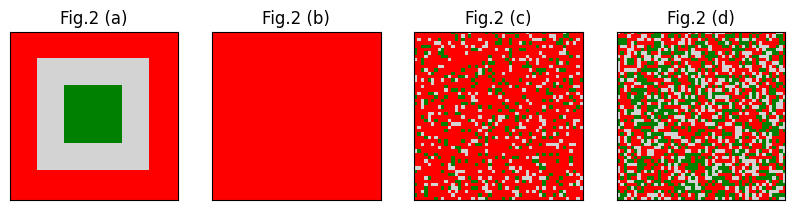

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(10, 10))

simulator.plot_grid(title="Fig. 2. (a)", ax = axs[0])

simulator.run_simulation(num_steps= 330, P = 1, Mf = 0, macro_info= "negative")
simulator.plot_grid(title = "Fig. 2. (b)", ax = axs[1])

simulator.run_simulation(num_steps= 370, P = 0.75, Mf = 0, macro_info= "negative")
simulator.plot_grid(title = "Fig. 2. (c)", ax = axs[2])

simulator.run_simulation(num_steps= 370, P = 0.5, Mf = 0, macro_info= "negative")
simulator.plot_grid(title = "Fig. 2. (d)",  ax = axs[3])

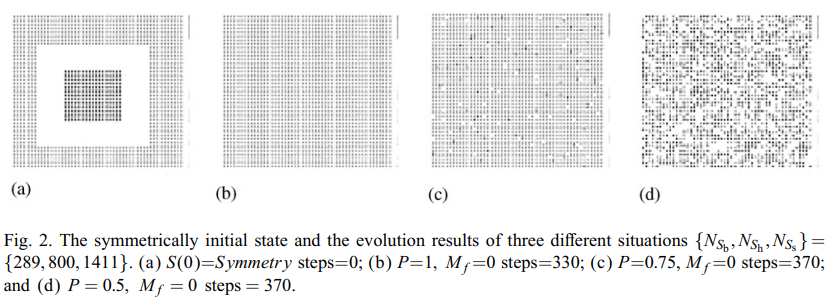 (*Original Fig. 2 taken from the paper*)

### Description of the Figure 2

#### Figure 2

The first situation describes the deterministic evolution rule and the second and third are the random evolution rules. 

**Fig. 2. (b)**

The first situation means that the investment behavior of the investors is the same as that used by the investors around them.

*Fig. 2b* indicates that the trend in the stock market was that the behavior of all cellular automata was selling, which was determined by the investors’ strong imitation behavior in the deterministic rules and the number and shape of the uneven distribution of the investment behavior in the symmetric rules.

**Fig. 2. (c) and (d)**

The investors in the second situation imitate with some probability, i.e., the investors have their own views except imitation, but the value of the coefficient of the investment preference in the third situation is smaller than that in the second, so the investors in the third situation invest more independently. 

In *Fig. 2c*, most of the behavior was selling (*in the original paper they wrote "buying", but it's probably a typo, as it doesn't correspond to the picture*) and the other behavior sporadically scattered and the positions and the number of the behavior changed in the small scope, which was a phenomenon far from equilibrium. It reflects that the investment behavior of investors with their own ideas can make the market partly stable. 

*Fig. 2d* manifests that the market entered a stable state only after a few steps. At that time the three types of investment behavior were evenly scattered. Although their numbers changed as time went on, the swing was small, which was the stable equilibrium market. It embodies that the independent investment behavior in the stock market has the ultimate influence on the market stability.
___
These three situations illustrate the process where the investors step by step change from complete imitation to independency. During this process, the evolution results in the stock market began from an extreme situation that a type of behavior took up the whole space, and gradually entered a stable equilibrium market from a non-equilibrium market in which the value of the coefficient of the investment preference decreased bit by bit.

This indicates that the bigger the value of the coefficient of the investment preference, the more unstable the stock market, and the smaller the value of the coefficient of investment preference, the more stable the stock markets.



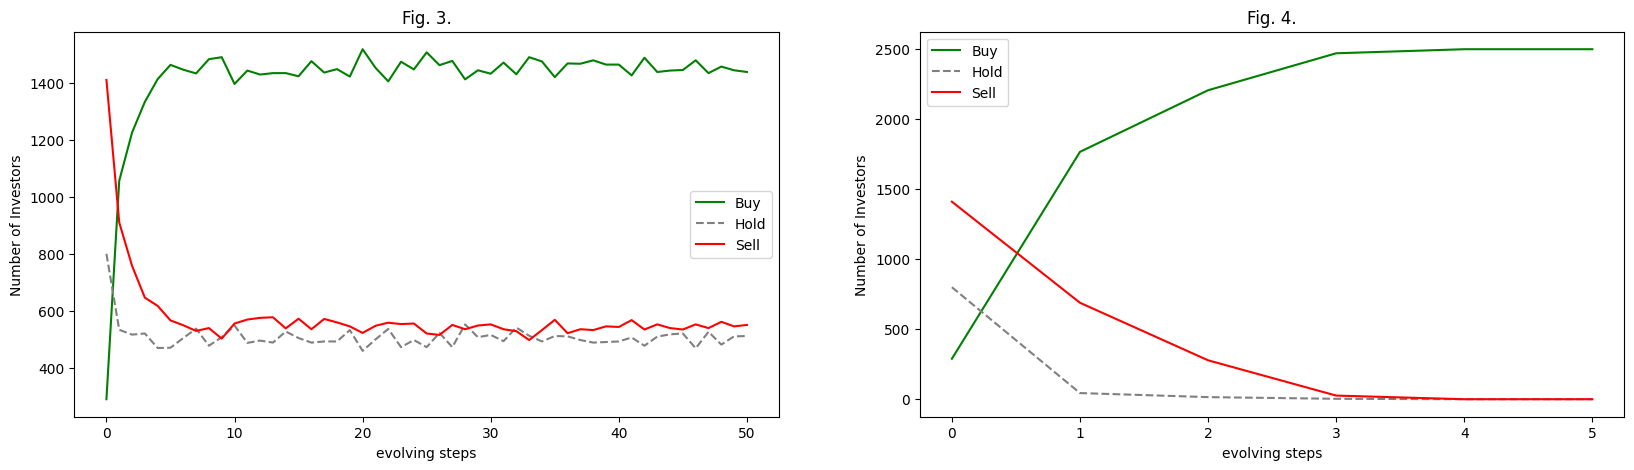

In [4]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

simulator.run_simulation(num_steps= 51, P = 0.5, Mf = 0.1, macro_info= "positive")
simulator.plot_hist(title = "Fig. 3.", ax = axs[0])

simulator.run_simulation(num_steps= 6, P = 0.5, Mf = 0.9, macro_info= "positive")
simulator.plot_hist(title = "Fig. 4.", ax = axs[1])



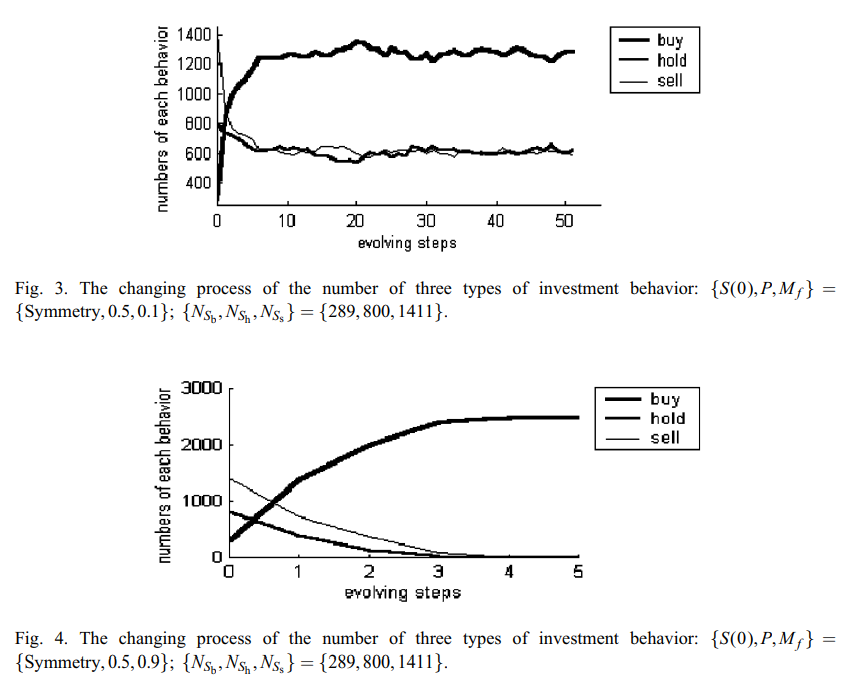 (*Original Fig. 3 and 4 taken from the paper*)

### Description of Figures 3 and 4

Figs. 3 and 4 make it clear that the positive macro information makes the value of the buying probability increase, and the differently positive extent will result in the different evolution results of the stock market. 

While the common positive information appeared, although the buying behavior of the investors increased (shown in Fig. 3), the stock market finally tended towards a stable state because of the part independency of the investors. The total number of the buying behavior maintained the weak oscillation at a high position and that of the holding and selling behavior kept the weak oscillation also at a low position. 

While the uncommon positive information appeared, the investors did their best to buy, which caused the buying behavior of the investors to take up the whole simulation space and made the stock market fluctuate violently (shown in Fig. 4). It is illustrated that the bigger the value of the macro coefficient, the more unstable the stock market, and the smaller, the more stable.

### Some Simulations With Random Starting Grid

In [28]:
random_simulator = MarketSimulator2D_CA(grid_size=50, symmetric= False)

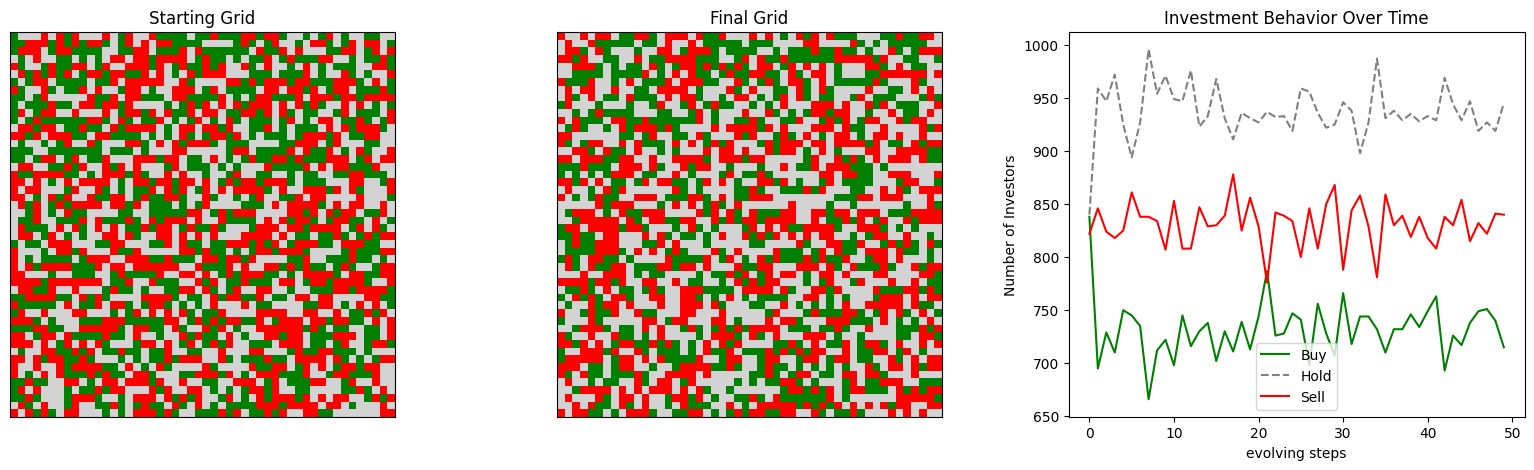

In [29]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

random_simulator.plot_grid(title = "Starting Grid", ax = axs[0])
random_simulator.run_simulation(num_steps= 50, P = 0.2, Mf = 0.05, macro_info= "positive")
random_simulator.plot_grid(title = "Final Grid", ax = axs[1])
random_simulator.plot_hist(ax = axs[2])

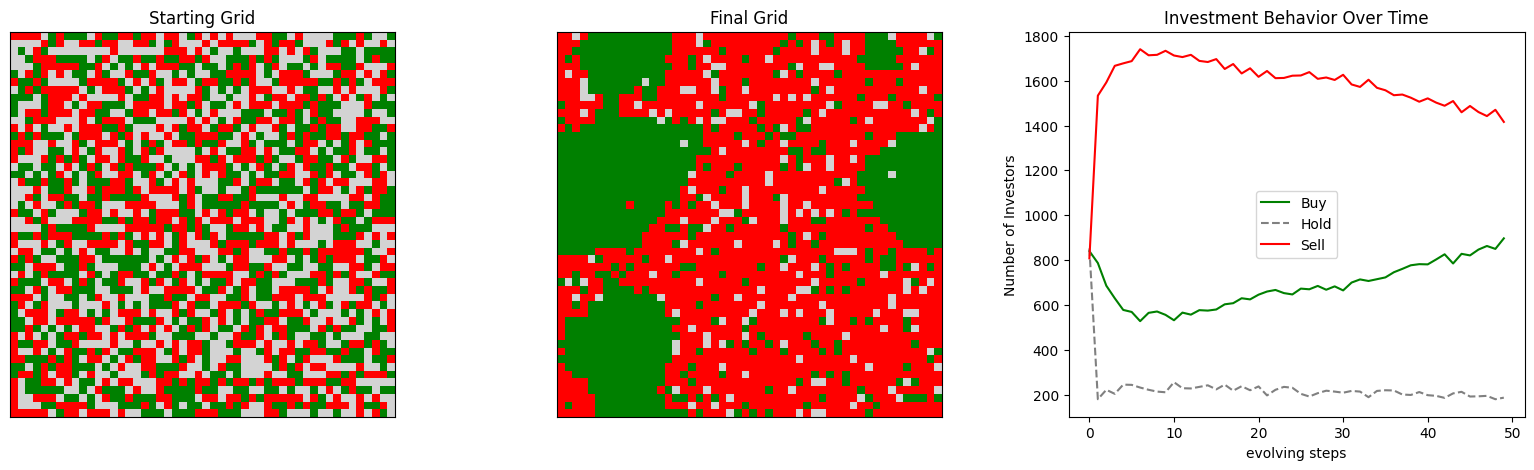

In [40]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

random_simulator = MarketSimulator2D_CA(grid_size=50, symmetric= False)
random_simulator.plot_grid(title = "Starting Grid", ax = axs[0])
random_simulator.run_simulation(num_steps= 50, P = 0.99, Mf = 0.2, macro_info= "negative")
random_simulator.plot_grid(title = "Final Grid", ax = axs[1])
random_simulator.plot_hist(ax = axs[2])

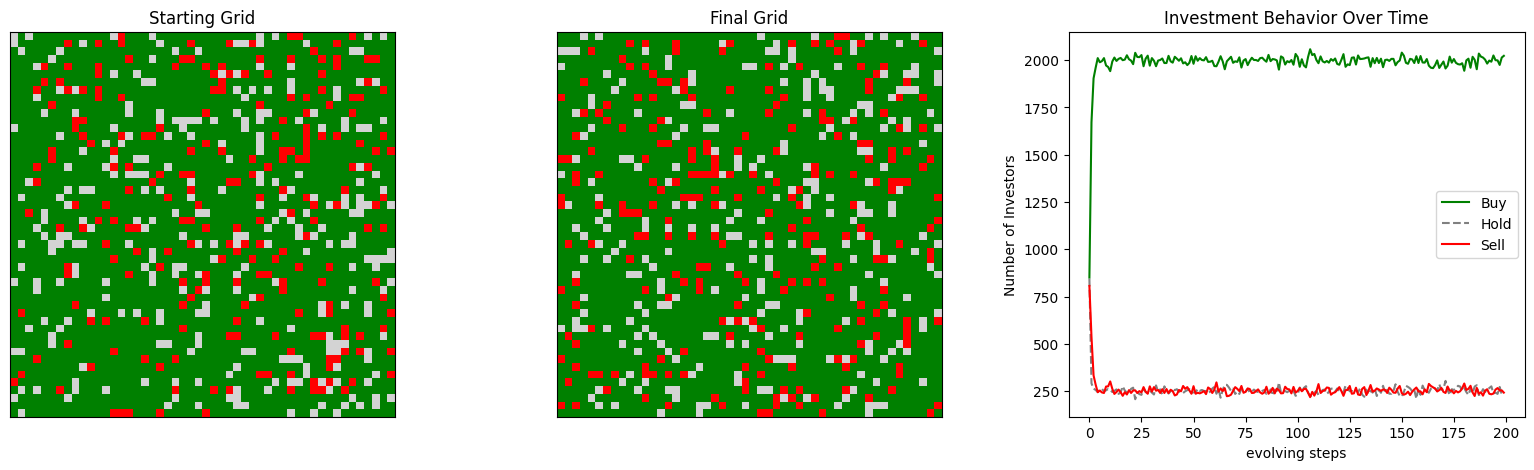

In [32]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

random_simulator.plot_grid(title = "Starting Grid", ax = axs[0])
random_simulator.run_simulation(num_steps= 200, P = 0.6, Mf = 0.2, macro_info= "positive")
random_simulator.plot_grid(title = "Final Grid", ax = axs[1])
random_simulator.plot_hist(ax = axs[2])

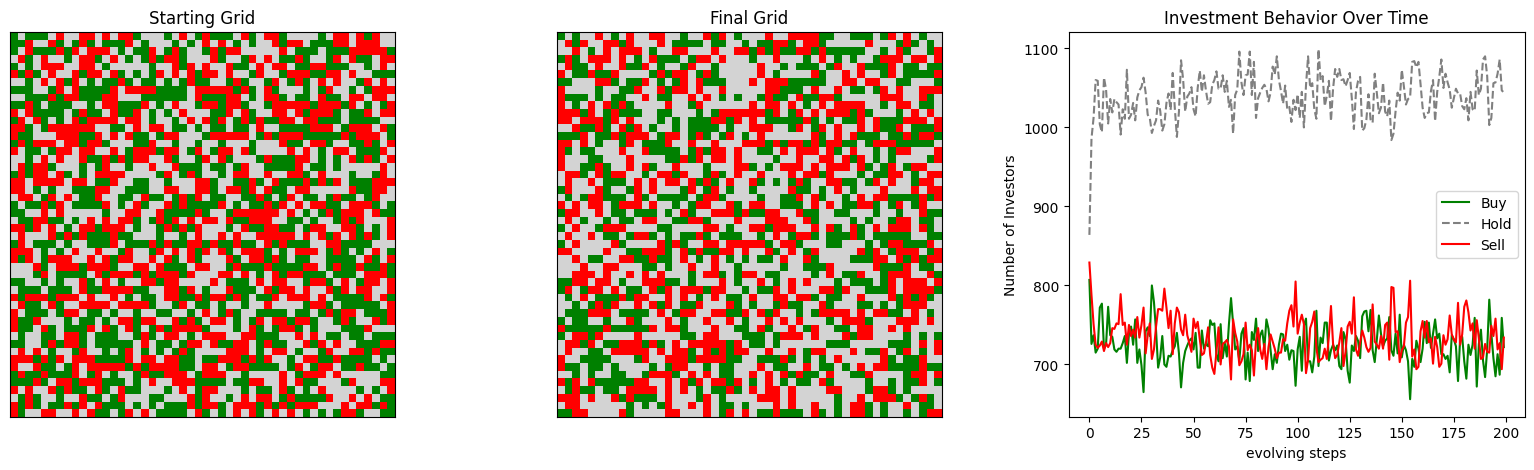

In [33]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

random_simulator = MarketSimulator2D_CA(grid_size=50, symmetric= False)
random_simulator.plot_grid(title = "Starting Grid", ax = axs[0])
random_simulator.run_simulation(num_steps= 200, P = 0.5, Mf = 0.1, macro_info= "none")
random_simulator.plot_grid(title = "Final Grid", ax = axs[1])
random_simulator.plot_hist(ax = axs[2])

We report here the conclusion of the paper we've successfully replicated in this paper.

### Conclusion

By the analysis of the simulation results of the investment behavior in the stock market, it could be concluded as follows:

1.  While the imitation appears in the stock market, the evolution result of the stock market sensitively depends on the initial state and different initial states will cause the different evolution results. Evolution results are closely related to the initial states, but no law exists between them. The final evolution results of the stock market cannot be predicted, which reveals the complexity of the complex system of the stock market.

2.  The investment preference is the key factor affecting the stability of the stock market. The bigger the value of the coefficient of the investment preference, the more unstable is the stock market, and vice versa. The big value of the investment preference coefficient corresponds to stronger imitation mentality, that is, the performance behavior of the investor will be affected highly by the other investors’ behavior. If all investors are influenced by each other, “herd effect” is easily caused and so is a huge fluctuation of the stock market. While the value of the coefficient of the investment preference is very low, the imitation mentality is very weak and the investment behavior is very independent, benefiting the stability of the stock market.

3.  The macro factor is one of the important factors affecting the stability of the stock market. The bigger the value of the macro coefficient the more unstable is the stock market, and vice versa. While only the common macro information appears, three kinds of investment behavior are just redistributed in the stock market, and while the macro information is uncommon, the stock market will finally collapse.

4.  Both investment preference and macro factors have influence on the stability of the stock market. Appearance of the latter cannot be avoided, and is sure to affect the investment behavior, but the former can be adjusted by persons. The imitation mentality goes against the yield and stability of the stock market. So, the investors should imitate less and form their opinions.

According to these primitive results of simulation of investment behavior in the stock market, we can see that cellular automata, an important tool for probing the complexity of systems, manifest huge potential in the research on the complexity in stock markets.